In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import math
import os
from IPython.display import display, HTML
print(os.getcwd())
from utils import Utils
from sym import Sym
from random import randint

c:\Users\Davide Vidmar\Documents\UniTs\Stocha\project-stoch-2


We as first set initial parameters

In [10]:
eqThreshold = 6                     # Specify EQ magnitude over which Emergency has to be considered
eqA, eqB = 1.8, 0.4                 # Specify terrain parameters (for Richter eq.)
hRainThreshold = 800                # Specify treshold over which is considered to be 'heavy'
visibilityThreshold = 700           # Specify threshold over which poor visibility becomes non neglectable 
period = 360 * 50                   # Specify years of simulation
forecastingPeriod = 360*10          # Specify time-horizon in forecasting analisys
numSamples = 15                     # Specify number of scenarios included in analisys

Let'run our simulation;
The first stage of the process consists of symulating wet/dry days by means of a 2-states markov process: dry days or wet days.
Each trasnsition is associated to a transition probability, then we have: 
$$M = \begin{pmatrix}
p_{00} & p_{01} \\
 p_{10} & p_{11}
\end{pmatrix}$$

$$p_{01}:  \text{probability of wet day after dry day} \\
p_{11}:  \text{probability of wet day after wetday} \\
p_{00} = 1 -  p_{01} \\
p_{10} = 1 -  p_{11}
$$


Each "weather game" iterates as follows:
![weather game](./images/weather-game.png "Title")



For each day model "decides" wether it is rainy or not, if yes then calculates the effectively rain amount by using an exponential distribution of mean u $$f(x) = (1/\mu ) \mathrm{e}_{}^{-x/\mu}$$
if no, rain amount is zero.

Next we proceed to sample non precipitational variable, that are:
<ul>
<li> Min temperatures </li>
<li> Max temperatures </li>
<li> Solar radiation </li>
</ul>
Note:
Those quantities, are poorly considered for the natural disaster triggering, but are usefull to compute severity parameters during an evacuation, affecting driving and operation times, visibility etc.

Quantities, (t_min, t_max, rad) are extracted from a stochastic Auto Regressive first-order process, defined by:
$$z(t) = Az(t-1) + B \epsilon(t) $$
where 
$$ z(t) =  \begin{pmatrix}
\mathrm{z}_{t_m}^{} \\
\mathrm{z}_{t_M}^{} \\
 \mathrm{z}_{rad}^{}\\

\end{pmatrix}

\\\epsilon(t) \sim G(0, 1)
$$ 
and 

$$
A = \begin{pmatrix}
0.567 & 0.086 & -0.002 \\
0.253 & 0.504 & -0.05 \\
-0.006 & -0.039 & 0.244
\end{pmatrix}

B = \begin{pmatrix}
0.781& 0 & 0 \\
0.328 & 0.637 & 0 \\
0.238 & -0.341 & 0.873
\end{pmatrix}
$$

Note: A and B are given from [PAPER]


Once they have been generated, the z(t) are transformed to weather
variables in a way that depends on whether the day has been simulated to be wet or
dry
$$\mathrm{T}_{k}^{}(t) = \begin{cases} \mathrm{\mu}_{k,0}^{}(t) + \mathrm{\sigma}_{k,0}^{}(t) \mathrm{z}_{k}^{}(t) & \text{if is a dry day}
\\ \mathrm{\mu}_{k,1}^{}(t) + \mathrm{\sigma}_{k,1}^{}(t) \mathrm{z}_{k}^{}(t) & \text{if is a wet day}
\end{cases}$$

Where seasonal fluctuation are considered by imposing to means a sinusoidal time-dependent behaviour, indeed:
$$\mu(t) = \overline{\mu} + C cos (0.0172(t -T))$$


{p01: 5.89888273533717e-6, p11: 0.994556307602081}
Predicted data: [[ 1.59786032e+03  7.98900217e+02  7.98917856e+02]
 [ 7.80463632e-02  1.00640638e-01  7.58040121e-02]
 [ 1.08256174e-01  7.10394107e-02  2.68039904e-01]
 [ 1.16911992e-01 -5.92345253e-02 -8.39203096e-02]
 [ 1.38685368e-01  2.44446734e-02  1.03117950e-01]
 [ 1.22986304e-01 -9.15725044e-02  8.48712498e-02]
 [-4.78892942e-02  6.59915079e-02 -1.35643145e-01]
 [ 8.57498505e-02  1.61280781e-01  1.72768545e-03]
 [ 9.85491448e-03 -1.36189776e-01 -2.67932779e-02]
 [ 1.39021760e-02  1.36813964e-01  1.48855000e-01]
 [-7.29971249e-02  3.61422150e-03 -6.27201962e-02]
 [-4.44243505e-04 -1.76332223e-02  1.17099515e-01]
 [-5.74372193e-02  5.25112132e-02  3.85101882e-02]
 [ 2.95177699e-02 -3.86081014e-02  3.57048506e-02]
 [ 4.47200275e-02  8.97379305e-02  8.12786761e-02]
 [ 2.37265732e-03  7.35636093e-02  4.81709481e-02]
 [ 2.37138358e-01 -3.87374488e-02 -8.43978686e-02]
 [ 1.48614209e-01  2.74812462e-02 -2.37757313e-02]
 [-3.40488049e-

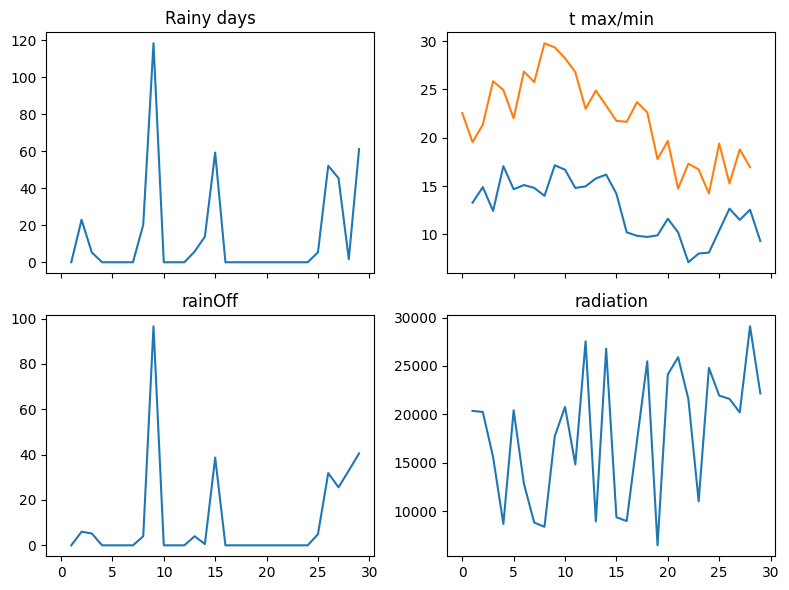

In [11]:
sym = Sym(period)
data = sym.getDf()
stats = sym.getDfStats()

# fig, axs = plt.subplots(2, 2)

# axs[0, 0].plot(data.rainAmount)
# axs[0, 1].plot(data.t_min)
# axs[0, 1].plot(data.t_max)
# axs[1, 0].plot(data.rainOff)
# axs[1, 1].plot(data.radiation)
# plt.show()

# print(data)

Now, let's collect data

In [12]:
dfAn = pd.DataFrame(columns=['day', 'month', 'season', 'year'])
days = [randint(1,forecastingPeriod) for _ in range(numSamples)]
# days = range(1,30*4)
dfAn['day']= days
dfAn['year'] = ([math.ceil(t/30/12) for t in days])
dfAn['month'] = ([math.floor((t)/30)%12 +1 for t in days])
dfAn['season'] = (([math.floor((t)/90)%4 +1 for t in days]))
display(dfAn)


,day,month,season,year
0,2132,12,4,6
1,711,12,4,2
2,1933,5,2,6
3,2003,7,3,6
4,520,6,2,2
5,3553,11,4,10
6,1197,4,2,4
7,3366,5,2,10
8,2594,3,1,8
9,2144,12,4,6


We are interested in probability of having a flood, so in order to quantify the risk we can use a simple relation, called the <a href="https://en.wikipedia.org/wiki/100-year_flood#:~:text=A%20100%2Dyear%20flood%20is,exceeded%20in%20any%20given%20year."> 100-year flood probability </a>, that is:
$$
p = 1 - [1 - (1/T)]^{n}
$$

Where P is the probability of having a flood in n years, giving a return period T.
We can then use generated data for the determination of T:
In fact, flood risk is proportional to the so called 'RainOff coefficient' which represents the total amount of whater that is not retained by the terrain and is instead free to flow and collect in rivers and channels.
The rainoff coefficient Q is then given by:
$$
Q= \frac{{\left( P - \mathrm{I}_{a}^{} \right)}^2}{P-\mathrm{I}_{a}^{}+S}
$$
Where P is the total rain amount for each day, Ia and S parameters of the terrain that describe capability of the ground to retain water.
Then T is considered to be the sampled mean time between two rainoff threshold exeedance. 

In [13]:
floodReturnPeriod = [stats.floodReturnPeriod[month-1] for month in dfAn.month.values]
dfAn['FloodRisk'] = [1 - (1-1/floodReturnPeriod[i])** dfAn.year[i] for i in dfAn.year.values]

Similarly, we apply the return period formula to earth quakes; here the return period is computed as the inverse of the frequency.
This frequency is computed starting from A and B which are parameters in the Richter distribution, that in this model have to be considered given by the model, and the determination of those teo parameters are out of the scope of this research.

So thath, we consider the <a  href="https://en.wikipedia.org/wiki/Gutenberg%E2%80%93Richter_law"  > Gutenberg-Richter distribution </a>:
$$
N = \mathrm{10}_{}^{a-bM}
$$

Where N is the total number of earthquakes at least of magnitude M, as said before, a and b are given parameters, during a period of study say of 200 years.
Again, we consider those quantities to be given by the model

In [14]:
numberOfEQ = 10**(eqA - eqB*eqThreshold)
eqPeriod = 200
eqFrequency = numberOfEQ / eqPeriod

dfAn['EqRisk'] =  [1 - (1-eqFrequency)** dfAn.year[i] for i in dfAn.year.values]#[1 - math.exp(-1*eqFrequency*dfAn.year.values[i]) for i in dfAn.year.values]

Then we can move to compute other quantities that are not directly relatred with a natural disaster but that can complicate or slow down rescue operations during one emergency, so that we consider:
<ul>
<li>Heavy rain: We set a rain threshold above which we consider it 'heavy'</li>
<li>Poor visibility: Another threshold below which visibility starts to be a serious issue</li>
<li>Below zero temperature: Risk of ice on roads</li>
<li>Expected population</li>
</ul>

In [15]:
heavyRainRisk = ([Utils.chebyshev(hRainThreshold, stats.meanRain[i], math.sqrt(stats.varRain[i])) for i in range(12)])
dfAn['HeavyRainRisk'] = [heavyRainRisk[i-1] for i in dfAn.month.values]

poorVisibilityRisk = ([Utils.chebyshev(visibilityThreshold, stats.meanRad[i], math.sqrt(stats.varRad[i])) for i in range(12)])
dfAn['poorVisibilityRisk'] = [poorVisibilityRisk[i-1] for i in dfAn.month.values]

dfAn['belowZeroRisk'] = [stats.belowZeroMean[i-1] for i in dfAn.month.values]

# dfAn['expectedPopulation'] = ([np.mean([data.population.loc[data['day'] == math.ceil(i%360)+1]]) for i in dfAn['day'].values])

dfAn.sort_values(by=['day'])

,day,month,season,year,FloodRisk,EqRisk,HeavyRainRisk,poorVisibilityRisk,belowZeroRisk
14,111,4,2,1,0.039600,0.002510,0.007365,0.269037,0.003333
4,520,6,2,2,0.058520,0.007512,0.004956,0.270981,0.018000
1,711,12,4,2,0.058520,0.007512,0.006350,0.271844,0.011333
6,1197,4,2,4,0.078400,0.002510,0.007365,0.269037,0.003333
2,1933,5,2,6,0.077632,0.005014,0.006234,0.289516,0.013333
3,2003,7,3,6,0.077632,0.005014,0.004917,0.295911,0.012667
0,2132,12,4,6,0.077632,0.005014,0.006350,0.271844,0.011333
13,2134,12,4,6,0.077632,0.005014,0.006350,0.271844,0.011333
9,2144,12,4,6,0.077632,0.005014,0.006350,0.271844,0.011333
12,2212,2,1,7,0.095618,0.012489,0.008422,0.270991,0.002667


Finally, we can normalize our probabilities in order to make them sum to one, considering every possible scenario.

,FloodRisk,EqRisk,HeavyRainRisk,poorVisibilityRisk,belowZeroRisk
0,0.052991,0.046592,0.063878,0.065002,0.076233
1,0.039945,0.069800,0.063878,0.065002,0.076233
2,0.052991,0.046592,0.062710,0.069227,0.089686
3,0.052991,0.046592,0.049461,0.070757,0.085202
4,0.039945,0.069800,0.049856,0.064795,0.121076
5,0.101868,0.092950,0.077029,0.067456,0.098655
6,0.053515,0.023325,0.074094,0.064331,0.022422
7,0.101868,0.092950,0.062710,0.069227,0.089686
8,0.101868,0.092950,0.072964,0.070035,0.035874
9,0.052991,0.046592,0.063878,0.065002,0.076233


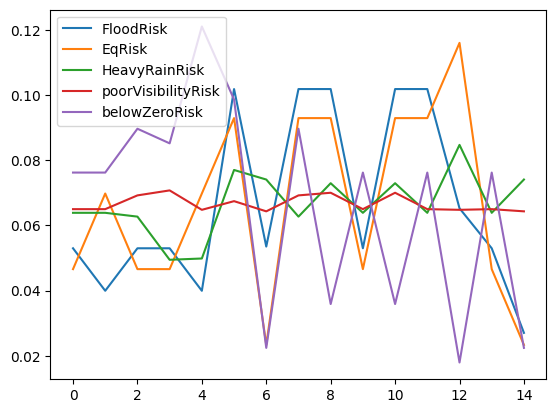

In [16]:
# dfAn['HRainRisk'] = data.rainAmount.loc[data['day'] == dfAn.day[0] ] 

normalizedDF = dfAn.iloc[:,4:].apply(lambda x: (abs(x))/sum(x), axis=0)

display(normalizedDF)
# plt.rc('axes',edgecolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')
normalizedDF.plot()

plt.savefig('grafico.png',transparent=True)

plt.show()